# setup

In [1]:
import asyncio
import aiohttp
import json
import os
from tqdm.notebook import tqdm

## change these parameters

In [21]:
# NUM_KIDS = 100 # per story

# HN_STORIES_JSON = '../../data/hn_stories_dataset_final.json' # raw stories data, used to fetch comments from kid ids
# HN_COMMENTS_JSON = '../../data/hn_comments_dataset_final.json' # store raw stories + comments
# HN_COMMENTS_CSV = '../../data/hn_comments_dataset_final.csv' # converted from json to csv
# HN_COMMENTS_SAMPLED_CSV = '../../data/sampled_400_hn_comments_ground_truth.csv' # uniformly sampled comments for ground truth

# # Define the base URL for the Hacker News API
# BASE_URL = 'https://hacker-news.firebaseio.com/v0'

# DEPTH = 1 # comments depth

NUM_KIDS = 100 # per story

# json's
HN_STORIES_JSON = '../../data/hn_stories_dataset_final.json' # contains the raw fetched hn stories and comment ids
HN_STORIES_GH_JSON = '../../data/hn_stories_dataset_gh_final.json'
HN_COMMENTS_JSON = '../../data/hn_comments_dataset_final.json'
HN_COMMENTS_GH_JSON = '../../data/hn_comments_dataset_gh_final.json'

# csv's
HN_STORIES_CSV = '../../data/hn_stories_dataset_final.csv' # after converting raw json to raw csv
HN_STORIES_GH_CSV = '../../data/hn_stories_dataset_gh_final.csv' # after converting raw json to raw csv
HN_COMMENTS_CSV = '../../data/hn_comments_dataset_final.csv' # after converting raw json to raw csv
HN_COMMENTS_GH_CSV = '../../data/hn_comments_dataset_gh_final.csv' # after converting raw json to raw csv
HN_COMMENTS_SAMPLED_CSV = '../../data/hn_comments_dataset_stratified_final.csv' # after converting raw json to raw csv

# txt's
KEYWORDS_TXT = 'ai_keywords.txt' # used to match relevant hn stories titles
HN_GITHUB_URLS_TXT = 'hn_github_urls.txt'

# Define the base URL for the Hacker News API
BASE_URL = 'https://hacker-news.firebaseio.com/v0'

# hackernews stories id's
CHATGPT_RELEASE_ID = 33804874 # nov 30th 2022
START_ID = 31300000 # may 8th 2022
END_ID = 40300000 # may 9th 2024

# dataset retrieval parameters
INCREMENT = 1 # 1: fetch every stories, 2: skip every other stories, 3: skip every 2 stories, etc.
DEPTH = 1 # comments depth, minimum as 1

# retrieve comments from stories

## setup methods

In [24]:
async def get_top_story_ids(session):
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        return await response.json()

async def get_item(session, item_id):
    async with session.get(f'{BASE_URL}/item/{item_id}.json') as response:
        return await response.json()

async def get_kids_hierarchical(session, item, depth=DEPTH):
    if 'kids' not in item or depth <= 0:
        return []

    kids_hierarchy = []
    tasks = []
    for kid_id in item['kids'][:NUM_KIDS]:
        tasks.append(get_item(session, kid_id))

    kids = await asyncio.gather(*tasks)
    for kid in kids:
        if kid:
            kid_data = {
                'id': kid.get('id'),
                'text': kid.get('text'),
                'time': kid.get('time'),
                'author': kid.get('by'),
                'depth': DEPTH - depth + 1,
                'children': await get_kids_hierarchical(session, kid, depth - 1)
            }
            kids_hierarchy.append(kid_data)
    return kids_hierarchy

def load_progress(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return {'processed_story_max_id': -1, 'stories': []}

def save_progress(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

async def retrieve_stories_comments(stories_source_filename, comments_dest_filename):
    stories_dest = load_progress(comments_dest_filename)
    progress_story_max_id = stories_dest['processed_story_max_id']
    stories_comments_dest = stories_dest['stories']
    curr_num_stories = len(stories_comments_dest)

    stories_source = load_progress(stories_source_filename)
    total_num_stories = len(stories_source['stories'])

    async with aiohttp.ClientSession() as session:
        pbar = tqdm(total=total_num_stories, desc="Fetching comments from stories")
        pbar.update(curr_num_stories)

        for story in stories_source['stories']:
            try:
                if story['id'] <= progress_story_max_id:
                    continue

                story['kids_text'] = await get_kids_hierarchical(session, story, depth=DEPTH)
                stories_comments_dest.append(story)

                pbar.update(1)
                progress_story_max_id = story['id']
                save_progress({'processed_story_max_id': progress_story_max_id,
                               'stories': stories_comments_dest}, comments_dest_filename)
            except Exception as e:
                print(f"Error processing story {story['id']}: {e}")
                save_progress({'processed_story_max_id': progress_story_max_id,
                               'stories': stories_comments_dest}, comments_dest_filename)
        pbar.close()
    return stories_comments_dest

## running

In [25]:
try:
    # Process the stories and fetch comments
    processed_data = await retrieve_stories_comments(HN_STORIES_JSON, HN_COMMENTS_JSON)

    print('Done')
except Exception as e:
    print(f"Error: {e}")

Fetching comments from stories:   0%|          | 0/4645 [00:00<?, ?it/s]

CancelledError: 

# counting

## github projects only

## setup method

In [ ]:
def count_comments(data):
    return len(data), sum(len(story['kids_text']) for story in data)

## github projects only

In [6]:
with open(HN_COMMENTS_GH_JSON) as f:
    data = json.load(f)

num_stories, num_comments = count_comments(data)
print(f"Total number of stories: {num_stories}")
print(f"Total number of comments: {num_comments}")

Total number of stories: 354
Total number of comments: 4707


## all discussions

In [ ]:
with open(HN_COMMENTS_JSON) as f:
    data = json.load(f)

num_stories, num_comments = count_comments(data)
print(f"Total number of stories: {num_stories}")
print(f"Total number of comments: {num_comments}")

# convert from json to csv

## setup methods

In [7]:
import json
import csv
import html
from datetime import datetime
import re
from bs4 import BeautifulSoup

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def extract_github_urls(text):
    github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+(?:/(?:issues|pull)/\d+)?"
    return list(set(re.findall(github_url_pattern, text)))

def is_github_repo_or_issue(url):
    if not url.startswith("https://github.com/"):
        return "Not GitHub"
    if "/issues/" in url:
        return "GitHub Issue"
    if "/pull/" in url:
        return "GitHub PR"
    return "GitHub Repo"

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')

def clean_html(html_text):
    if html_text is None:
        return ''
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

def flatten_comments(comments, discussion_id, title, url, discussion_date, parent_id=None, depth=0):
    flattened = []
    if not isinstance(comments, list):
        print(f"Warning: comments is not a list. Type: {type(comments)}")
        return flattened

    for i, comment in enumerate(comments):
        if not isinstance(comment, dict):
            print(f"Warning: comment {i} is not a dict. Type: {type(comment)}")
            continue

        comment_id = comment.get('id', '')
        comment_text = comment.get('text')
        if comment_text is None:
            print(f"Warning: comment {comment_id} has None text")
            comment_text = ''
        else:
            comment_text = clean_html(comment_text)
        comment_date = unix_to_datetime(comment.get('time', 0))
        comment_author = comment.get('author', '')

        flattened.append({
            'discussion_id': discussion_id,
            'title': title,
            'url': url,
            'discussion_date': discussion_date,
            'comment_id': comment_id,
            'parent_id': parent_id,
            'depth': depth,
            'comment_text': comment_text,
            'comment_date': comment_date,
            'comment_author': comment_author,
        })

        children = comment.get('children', [])
        if isinstance(children, list):
            flattened.extend(flatten_comments(children, discussion_id, title, url, discussion_date, comment_id, depth + 1))
        else:
            print(f"Warning: children for comment {comment_id} is not a list. Type: {type(children)}")

    return flattened

def process_stories(discussions):
    rows = []
    github_urls = set()

    for i, discussion in enumerate(discussions['stories']):
        discussion_id = discussion.get('id')
        title = discussion.get('title', '')
        url = discussion.get('url', '')
        discussion_date = unix_to_datetime(discussion.get('time', 0))

        print(f"Processing discussion {i+1}: ID {discussion_id}, Title: {title[:30]}...")

        github_urls.update(extract_github_urls(title))
        github_urls.update(extract_github_urls(url))

        comments_hierarchy = discussion.get('kids_text', None)
        if comments_hierarchy is not None:
            # print(f"  Found {len(comments_hierarchy)} top-level comments")
            for j, comment in enumerate(comments_hierarchy):
                comment_text = comment.get('text', 'N/A')
                comment_text_preview = comment_text[:30] if comment_text is not None else 'None'
                # print(f"    Comment {j+1}: ID {comment.get('id', 'N/A')}, Author: {comment.get('author', 'N/A')}, Text: {comment_text_preview}...")
            rows.extend(flatten_comments(comments_hierarchy, discussion_id, title, url, discussion_date))
        else:
            # print("  No comments found for this discussion")
            rows.append({
                'discussion_id': discussion_id,
                'title': title,
                'url': url,
                'discussion_date': discussion_date,
                'comment_id': '',
                'parent_id': '',
                'depth': 0,
                'comment_text': '',
                'comment_date': '',
                'comment_author': '',
            })

    print(f"Processed {len(discussions['stories'])} discussions, found {len(rows)} total comments")
    return rows, github_urls

def write_csv(filename, data, fieldnames):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)


## github projects only

In [ ]:
hn_comments_data = read_json_file(HN_COMMENTS_GH_JSON)

comments_rows, comments_github_urls = process_stories(hn_comments_data)

fieldnames = [
    'discussion_id',
    'title',
    'url',
    'discussion_date',
    'comment_id',
    'parent_id',
    'depth',
    'comment_text',
    'comment_date',
    'comment_author',
]

write_csv(HN_COMMENTS_GH_CSV, comments_rows, fieldnames)

## all discussions

In [ ]:

hn_comments_data = read_json_file(HN_COMMENTS_GH_JSON)

comments_rows, comments_github_urls = process_stories(hn_comments_data)

fieldnames = [
    'discussion_id',
    'title',
    'url',
    'discussion_date',
    'comment_id',
    'parent_id',
    'depth',
    'comment_text',
    'comment_date',
    'comment_author',
]

write_csv(HN_COMMENTS_GH_CSV, comments_rows, fieldnames)

# stratified sampling (for finding ground truth)

In [28]:
import pandas as pd
import numpy as np

def stratified_sample_with_min_per_story(csv_file, num_samples, output_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Remove comments that are marked as "[dead]" or "[flagged]"
    df = df[~df['comment_text'].isin(["[dead]", "[flagged]"])]

    # Remove empty comments
    df = df[df['comment_text'].notna()]

    # Drop duplicates based on both 'comment_id' and 'comment_text'
    df = df.drop_duplicates(subset=['comment_id', 'comment_text'])

    # Group by 'discussion_id' (which represents each story)
    grouped = df.groupby('discussion_id')

    # Initialize an empty DataFrame to store the sampled data
    sampled_df = pd.DataFrame()

    # Step 1: Ensure each story gets at least one comment
    for name, group in grouped:
        if len(group) > 1:
            sampled_df = pd.concat([sampled_df, group.sample(n=1, random_state=42)])
        else:
            sampled_df = pd.concat([sampled_df, group])

    # Step 2: Calculate the remaining number of comments to sample
    remaining_samples = num_samples - len(sampled_df)

    if remaining_samples > 0:
        # Step 3: Sample the remaining comments proportionally to the size of each group
        proportion = remaining_samples / (len(df) - len(sampled_df))

        # Remove the previously sampled data from the original dataframe to avoid duplicates
        df_remaining = df[~df.index.isin(sampled_df.index)]

        # Sample remaining comments proportionally
        remaining_sampled = df_remaining.groupby('discussion_id', group_keys=False).apply(
            lambda x: x.sample(frac=proportion, random_state=42) if len(x) > 1 else pd.DataFrame()
        )

        # Combine the guaranteed 1 comment samples with the remaining proportional samples
        sampled_df = pd.concat([sampled_df, remaining_sampled])

    # Ensure the final number of samples matches exactly num_samples
    if len(sampled_df) > num_samples:
        sampled_df = sampled_df.sample(n=num_samples, random_state=42)

    # Save the sampled data to a new CSV file
    sampled_df.to_csv(output_file, index=False)

# Example usage:
stratified_sample_with_min_per_story(HN_COMMENTS_GH_CSV, 400, HN_COMMENTS_GH_CSV)


C:\Users\prach\AppData\Local\Temp\ipykernel_8860\1839534100.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  remaining_sampled = df_remaining.groupby('discussion_id', group_keys=False).apply(


# show comments statistics

In [9]:
import pandas as pd

def get_comment_statistics(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Calculate overall statistics
    total_stories = comment_counts['discussion_id'].nunique()
    total_comments = comment_counts['num_comments'].sum()
    max_comments = comment_counts['num_comments'].max()
    min_comments = comment_counts['num_comments'].min()
    avg_comments = comment_counts['num_comments'].mean()

    # Print the statistics
    print(f"Total number of stories: {total_stories}")
    print(f"Total number of comments: {total_comments}")
    print(f"Average number of comments per story: {avg_comments:.2f}")
    print(f"Max number of comments in a story: {max_comments}")
    print(f"Min number of comments in a story: {min_comments}")

    # Return the DataFrame containing the number of comments per story
    return comment_counts


In [10]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_GH_CSV)
print(comment_stats)

Total number of stories: 348
Total number of comments: 4707
Average number of comments per story: 13.53
Max number of comments in a story: 98
Min number of comments in a story: 1
     discussion_id  num_comments
0         31355348             7
1         31405976             6
2         31846593            41
3         32458048            10
4         32628761            21
..             ...           ...
343       40226976             9
344       40237305             4
345       40252569            42
346       40285986             3
347       40291780             4

[348 rows x 2 columns]


In [31]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_GH_CSV)
print(comment_stats)

Total number of stories: 218
Total number of comments: 383
Average number of comments per story: 1.76
Max number of comments in a story: 6
Min number of comments in a story: 1
     discussion_id  num_comments
0         31533180             2
1         31555920             2
2         31662560             2
3         31776740             1
4         31934400             1
..             ...           ...
213       40189560             1
214       40215100             1
215       40259100             1
216       40265420             1
217       40291780             1

[218 rows x 2 columns]


# plot no. comments per story

## setup methods

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comment_distribution(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Sort by number of comments for better visualization
    comment_counts = comment_counts.sort_values(by='num_comments', ascending=False)

    # Plotting the distribution of comments per story
    plt.figure(figsize=(10, 6))
    sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')

    # Set the plot title and labels
    plt.title('Number of Comments per Story (discussion_id)', fontsize=14)
    plt.xlabel('Discussion ID (Story)', fontsize=12)
    plt.ylabel('Number of Comments', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\prach\AppData\Local\Temp\ipykernel_23192\4014733331.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


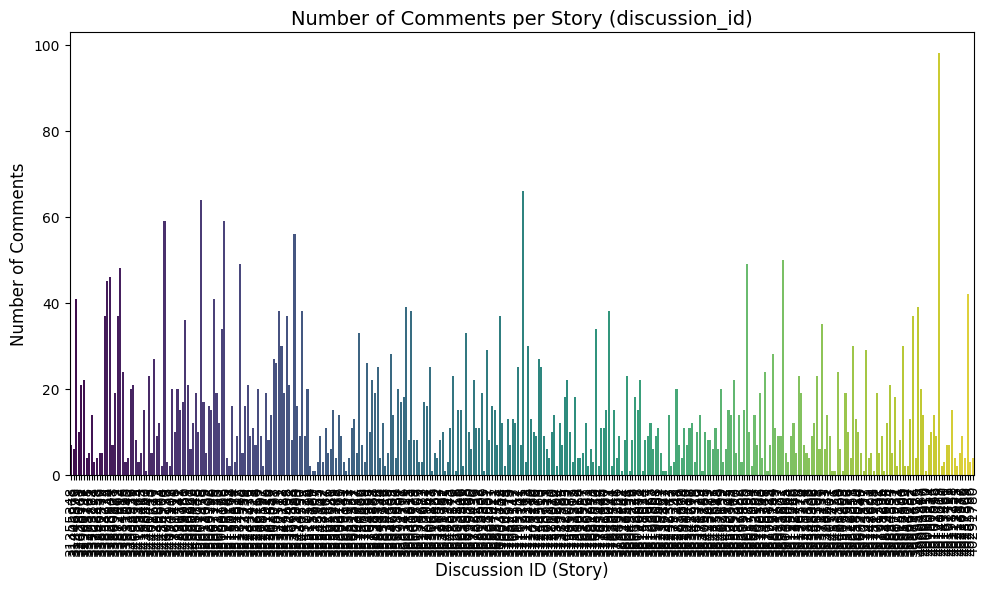

In [12]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_GH_CSV)

C:\Users\prach\AppData\Local\Temp\ipykernel_8860\4014733331.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


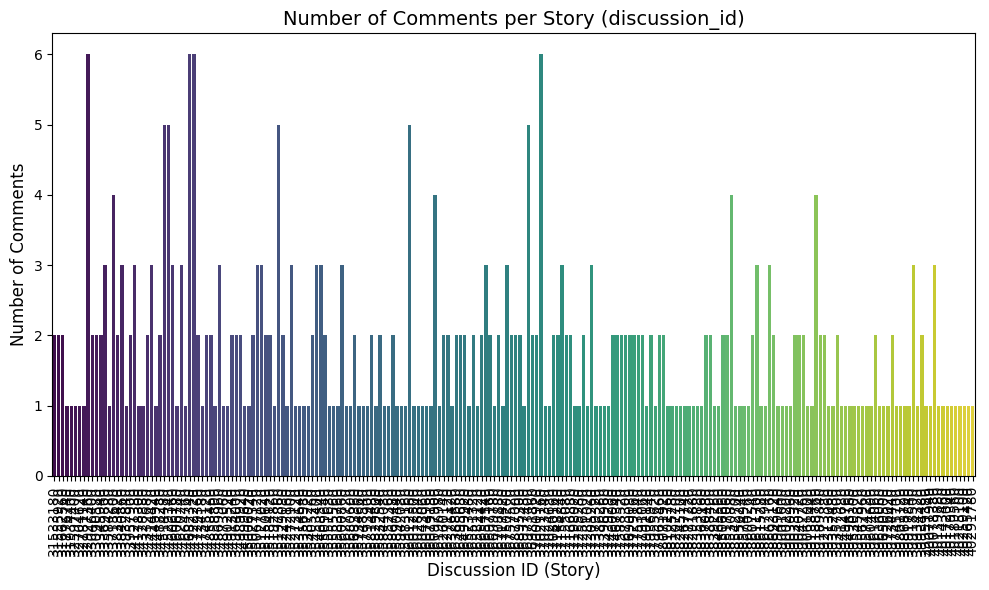

In [27]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_SAMPLED_CSV)

# plotting comment trend histogram

## setup method

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_comments_histogram(title, csv_file_path, bin_size_days=7):
    """
    Plot a histogram of AI discussion comments over time from a CSV file.

    Args:
    title (str): graph title
    csv_file_path (str): The path to the CSV file.
    bin_size_days (int): The size of each bin in days.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert comment_date to datetime
    df['comment_date'] = pd.to_datetime(df['comment_date'])

    # Create the histogram
    fig, ax = plt.subplots(figsize=(15, 7))

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Based on the start_id and end_id defined above
    total_days = (end_date - start_date) / (24*60*60)
    bins = int(total_days / bin_size_days)

    n, bins, patches = ax.hist(df['comment_date'], bins=bins, edgecolor='black')

    # Format x-axis ticks as dates
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

    # Set the number of ticks on the x-axis
    num_ticks = 5
    ax.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator(maxticks=num_ticks))

    plt.title(f'{title} (Bin Size: {bin_size_days} days)')
    plt.xlabel('Date')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45)

    # Add vertical line for ChatGPT release
    chatgpt_release = pd.Timestamp('2022-11-30')
    plt.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
    plt.legend()

    plt.tight_layout()
    plt.show()


## github projects only

C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:44: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.xticks(rotation=45)
C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:51: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
c:\Users\prach\miniconda3\envs\general\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


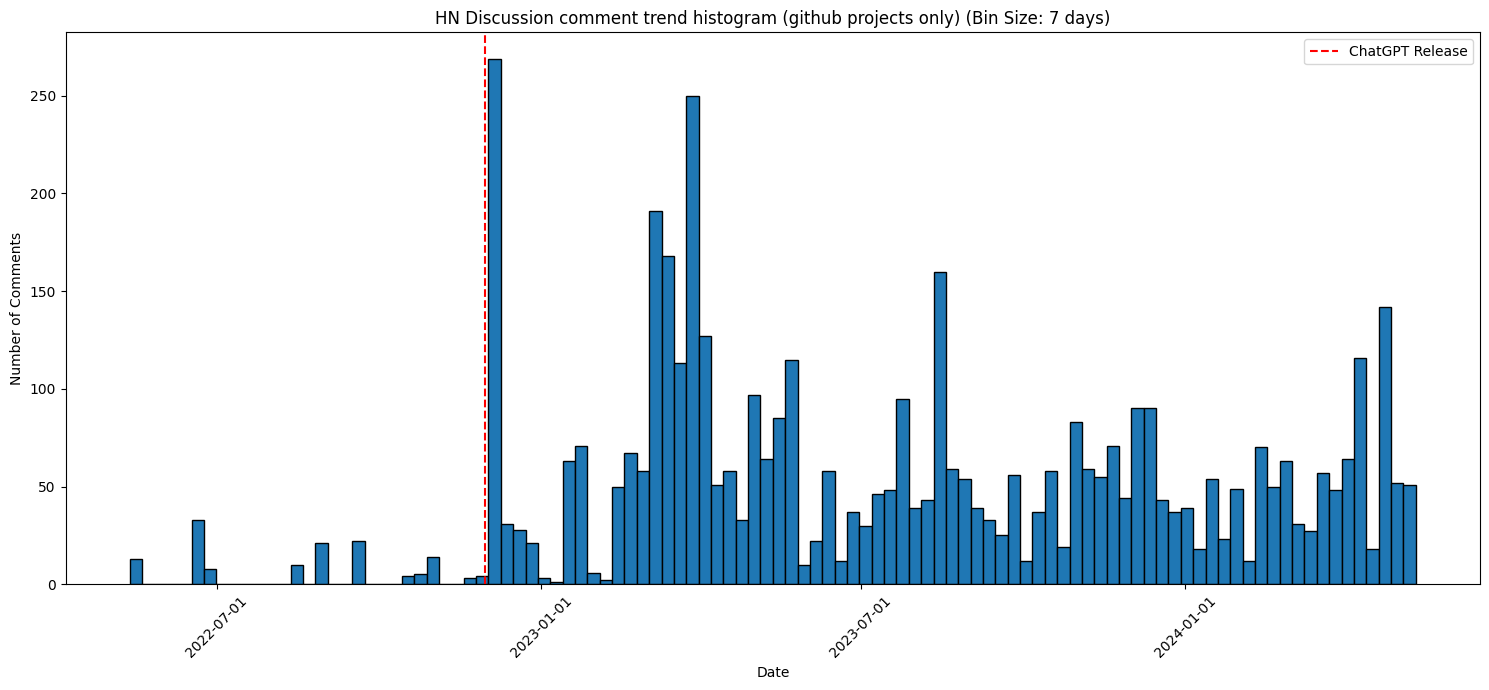

C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:44: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.xticks(rotation=45)
C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:51: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
c:\Users\prach\miniconda3\envs\general\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


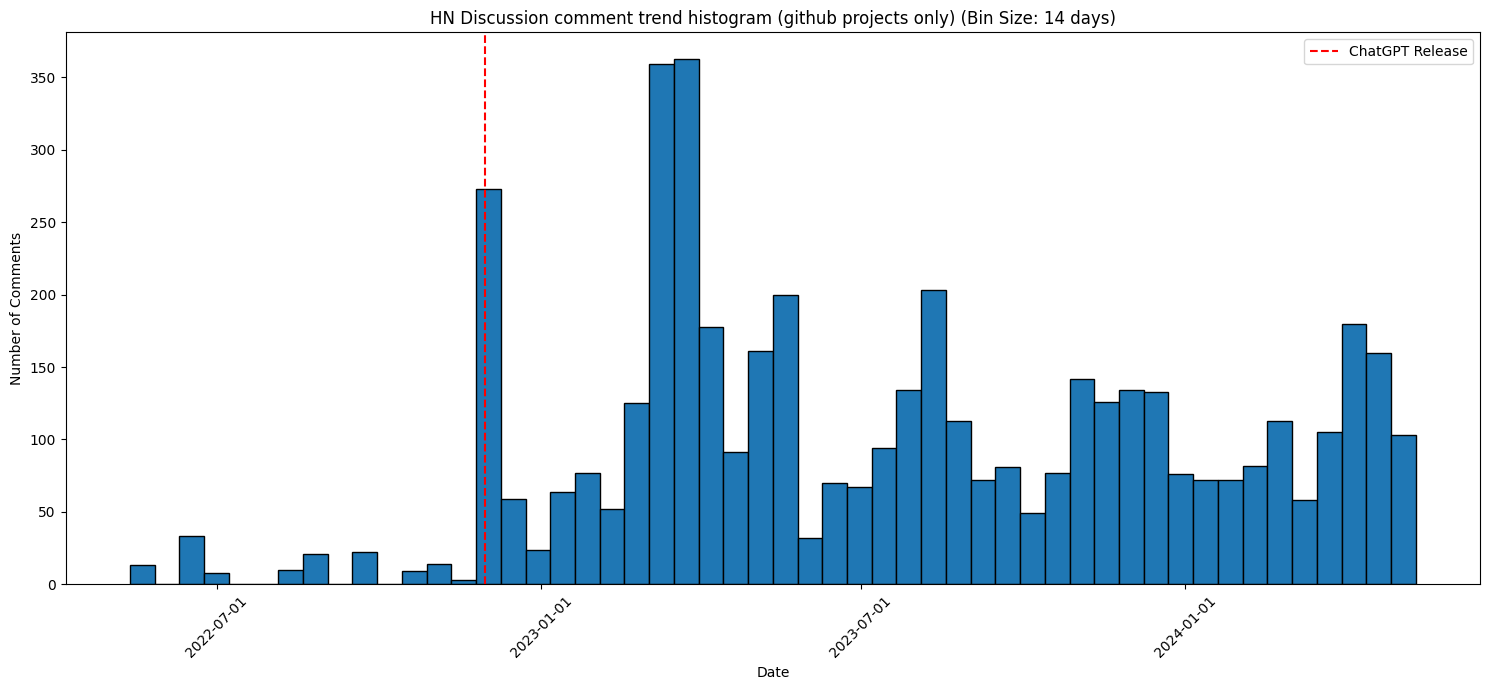

C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:44: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.xticks(rotation=45)
C:\Users\prach\AppData\Local\Temp\ipykernel_23192\1334104452.py:51: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
c:\Users\prach\miniconda3\envs\general\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


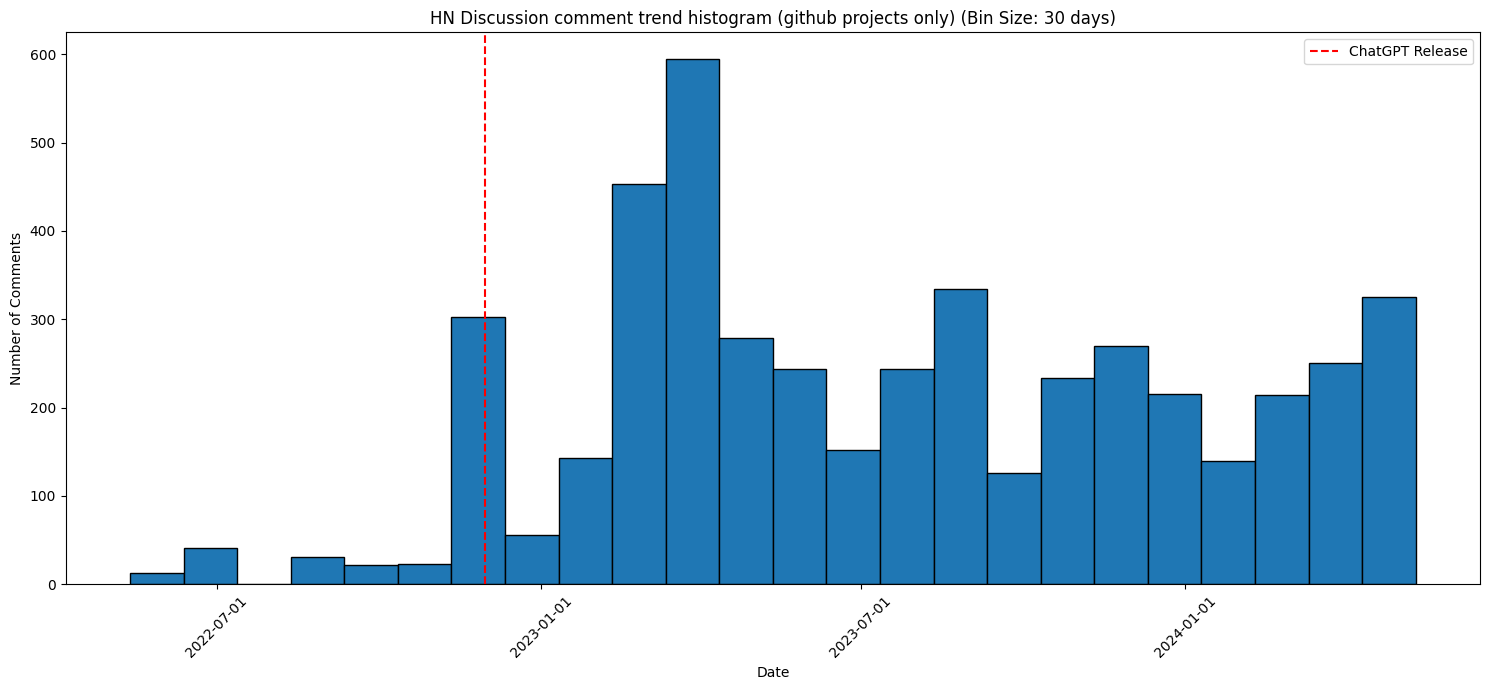

In [18]:
plot_comments_histogram("HN Discussion comment trend histogram (github projects only)", HN_COMMENTS_GH_CSV, bin_size_days=7)
plot_comments_histogram("HN Discussion comment trend histogram (github projects only)", HN_COMMENTS_GH_CSV, bin_size_days=14)
plot_comments_histogram("HN Discussion comment trend histogram (github projects only)", HN_COMMENTS_GH_CSV, bin_size_days=30)

# calculating trend statistics